In [44]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

In [45]:
r = 0.01          
sigma = 0.15      
T = 10             
S0 = 100           
guarantee = 100   
n = 10

In [46]:
def adaptedBinomialTree(r, sigma, T, guarantee, n):
    dt = T/n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u

    R_dt = np.exp(r*dt)  
    p = (R_dt - d) / (u - d)  
    q = 1 - p

    # Stock price calculations
    stockValues = np.zeros((n+1, n+1))
    stockValues[0,0] = 100  

    for i in range(1, n+1):
        stockValues[i,0] = u * stockValues[i-1,0]
        for j in range(1, i+1):
            stockValues[i,j] = d * stockValues[i-1,j-1]

    # Contract price calculations
    contractPrice = np.zeros((n+1, n+1))
    for i in range(n+1):
        contractPrice[n,i] = np.maximum(guarantee, stockValues[n,i])

    for i in range(n-1, -1, -1):
        for j in range(i+1):
            contractPrice[i,j] = (1 / R_dt) * (p * contractPrice[i+1,j] + q * contractPrice[i+1,j+1])

    # Delta hedge matrix
    deltaHedge = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1):
            deltaHedge[i,j] = (contractPrice[i+1,j] - contractPrice[i+1,j+1]) / (stockValues[i+1,j] - stockValues[i+1,j+1])

    return stockValues, contractPrice[0,0], deltaHedge

In [47]:
def closed_form_deltaHedge(S, t):
    d1 = (np.log(S/100) + (r + 0.5*sigma**2)*(T - t))/(sigma*np.sqrt(T - t))
    return norm.cdf(d1)

closed_form_delta_0 = closed_form_deltaHedge(S0, 0)
print(f"Closed-form delta Hedge at t=0: {closed_form_delta_0:.4f}")    

Closed-form delta Hedge at t=0: 0.6729


In [51]:
n_values = [10, 25, 50, 100, 400, 800, 1000]

for n in n_values:
    stockValues, contractPrice, deltaHedge = adaptedBinomialTree(r, sigma, T, guarantee, n)
    print(f"Steps: {n}, Delta: {deltaHedge[0, 0]:.4f}")

Steps: 10, Delta: 0.6689
Steps: 25, Delta: 0.6715
Steps: 50, Delta: 0.6721
Steps: 100, Delta: 0.6725
Steps: 400, Delta: 0.6728
Steps: 800, Delta: 0.6729
Steps: 1000, Delta: 0.6729


In [36]:
def plot_binomial_tree(stock_prices, deltas, steps):
    plt.figure(figsize=(12, 8))
    for i in range(steps + 1):
        for j in range(i + 1):
            #  stock prices
            plt.plot(i, stock_prices[i, j], 'bo')
            # Lines between nodes
            if i < steps:
                plt.plot([i, i + 1], [stock_prices[i, j], stock_prices[i + 1, j]], 'b-')
                plt.plot([i, i + 1], [stock_prices[i, j], stock_prices[i + 1, j + 1]], 'b-')
            
            # delta values at each node
            delta_val = deltas[i, j]
            plt.annotate(f"{delta_val:.2f}", (i, stock_prices[i, j]), textcoords="offset points", xytext=(0, 5), ha='center')

    plt.title("Binomial Tree for Stock Prices and Deltas")
    plt.xlabel("Time Step")
    plt.ylabel("Stock Price")
    plt.grid(True)
    plt.show()

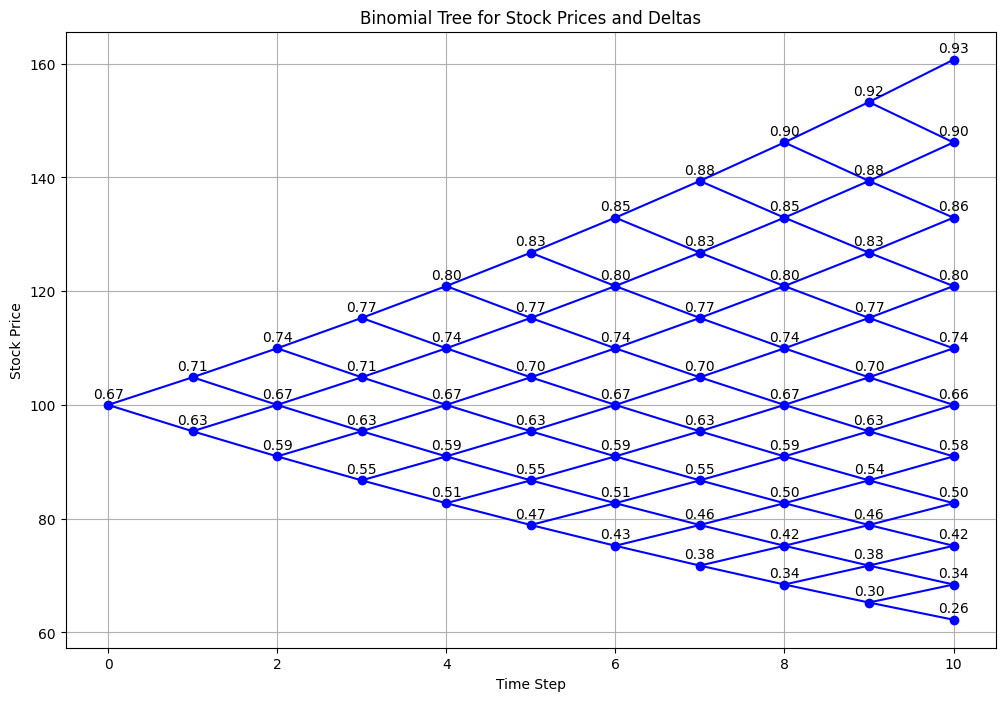

In [37]:
plot_binomial_tree(stockValues, deltaHedge, n)